## Topic Modelling on Twitter Data

In [217]:
# !pip install gensim 

In [218]:
# conda install -c conda-forge pyldavis

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gensim as gensim
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import re

import json
from googletrans import Translator

import seaborn as sns
import matplotlib.style as style
import matplotlib
import matplotlib.pyplot as plt

### Retrieve Data

In [220]:
# Retrieve data

tweets_df = pd.read_csv('combined_sg_tweets.csv', index_col=0)

print(tweets_df.shape)
tweets_df.head()

(6687, 4)


,username,text,date,processed_tweets
0,PuteriAmirah01,b'RT @rndsmsl: Kiamat dh dekat knp aku masih malas solat \xf0\x9f\x98\x94',2020-01-27,News Apocalypse is near why I'm still lazy prayers
1,joseph_yeow,b'RT @new_prykm: This video shows how South Korea Airport is dealing with #coronavirus #\xe0\xb9...,2020-01-27,This video shows how South Korea Airport is dealing with coronavirus from spreading
2,_naufalraffid,b'RT @L0s3r_AT_w0rk: Thomas had never seen such bullshit before\n#CoronaOutbreak https://t.co/RY...,2020-01-27,Thomas had never seen such bullshit before
3,FaadehlehHakehm,b'RT @chey_cobb: Chinese officials say this is a photo of a new hospital building in #Wuhan.\n\n...,2020-01-27,Chinese officials say this is a photo of a new hospital building in Wuhan because a reverse ima...
4,miz4h,"b'RT @putridamiaa: spread this, it\xe2\x80\x99s worth to share :) #coronarvirus https://t.co/rLA...",2020-01-27,spread this it worth to share coronavirus


In [221]:
# Get all tweets(string) in a list

tweets_list = tweets_df['processed_tweets'].tolist()

print("Total number of tweets: \n{} \n".format(len(tweets_list)))
print("Sample tweets: \n{}".format(tweets_list[:3]))

Total number of tweets: 
6687 

Sample tweets: 
["News Apocalypse is near why I'm still lazy prayers", ' This video shows how South Korea Airport is dealing with coronavirus  from spreading', ' Thomas had never seen such bullshit before']


### Tokenisation and Stop Words Removal

In [222]:
from nltk.tokenize import RegexpTokenizer
#splits string into substrings using a regular expression
#tokenises words that contain 1 or more (+) alphanumeric characters (\w) or '@'
retokenizer = RegexpTokenizer(r'[\w@]+')

# create stop words list
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# add twitter specific stop words
stop_words += ["rt", "got", "thats", "would", "going", "u", 
               "get", "also", "one", "could", "said", "like",
               "covid", "coronavirus", "covid_19", "covid19",
               "via", "say", "amp", "many", "need", "day",
               "coronavirusoutbreak", "covid2019", "want", "covid_",
               "last", "ncov", "novelcoronavirus", "people",
               "done", "two", "virus", "coronaviruspandemic",
               "outbreak", "know", "upon", "may", "way",
               "saw", "gtgt", "wuhanvirus", "brt", "2019ncov",
               "told", "wuhan", "china", "novel"
              ]

# create lemmatizer
wnl = nltk.stem.wordnet.WordNetLemmatizer()

In [223]:
def process_text(documents, stop_words):
    processed_docs = []
    doc_tokens = []
    for doc in documents:
        doc = str(doc).lower()
        doc_tokens = retokenizer.tokenize(doc)
        doc_tokens = [token for token in doc_tokens if token not in stop_words]
        doc_tokens = [token for token in doc_tokens if len(token)>2]
        doc_tokens = [wnl.lemmatize(token) for token in doc_tokens]    
        processed_docs.append(doc_tokens)
    return processed_docs

In [224]:
# Gets a list of list of tokens (each nested list is from one tweet)

processed_tweets = process_text(tweets_list, stop_words)

# print(processed_tweets)
print(len(processed_tweets))

6687


### Topic Modelling

#### 1 - Create a dictionary representaion
`gensim` dictionary assigns an integer id to each unique word in the corpus

In [225]:
# Create a dictionary representation of the documents. Each word gets an id
dictionary = gensim.corpora.Dictionary(processed_tweets)

print('Sample word to id mappings:\n', list(dictionary.items())[:75])
print('Total Vocabulary Size:', len(dictionary))

Sample word to id mappings:
 [(0, 'apocalypse'), (1, 'lazy'), (2, 'near'), (3, 'news'), (4, 'prayer'), (5, 'still'), (6, 'airport'), (7, 'dealing'), (8, 'korea'), (9, 'show'), (10, 'south'), (11, 'spreading'), (12, 'video'), (13, 'bullshit'), (14, 'never'), (15, 'seen'), (16, 'thomas'), (17, 'building'), (18, 'chinese'), (19, 'hospital'), (20, 'image'), (21, 'new'), (22, 'official'), (23, 'photo'), (24, 'reveals'), (25, 'reverse'), (26, 'search'), (27, 'share'), (28, 'spread'), (29, 'worth'), (30, 'alleged'), (31, 'brazil'), (32, 'different'), (33, 'epidemiologist'), (34, 'health'), (35, 'leak'), (36, 'ministry'), (37, 'par'), (38, 'say'), (39, 'someone'), (40, 'taken'), (41, 'working'), (42, 'change'), (43, 'disgusting'), (44, 'gam'), (45, 'habit'), (46, 'joke'), (47, 'matter'), (48, 'please'), (49, 'really2'), (50, 'retweet'), (51, 'serious'), (52, 'city'), (53, 'five'), (54, 'left'), (55, 'lockdown'), (56, 'mayor'), (57, 'million'), (58, 'resident'), (59, 'went'), (60, 'away'), (61,

#### 2 -  Set parameters
Filter the vocabulary based on frequency, so as not to use less important words or words that do not help differentiate the topics.

In [226]:
# Filter out words that occur in less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)
print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 477


#### 3 - Create the vector space model (bag of words model in gensim)
The function `doc2bow()` counts the number of occurrences of each unique word, converts the word to its integer word id and returns the result as a sparse vector(words from the dictionary not present in the document are not stored in the document vector)


In [227]:
# Transforming corpus into bag of words vectors
corpus_vect = [dictionary.doc2bow(text) for text in processed_tweets]

In [228]:
#Check how the vector looks for the second tweet document
print(corpus_vect[1])
print("\n", )
print(processed_tweets[1])

[(4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


['video', 'show', 'south', 'korea', 'airport', 'dealing', 'spreading']


In [229]:
# print(type(corpus_vect))
print(len(corpus_vect))

6687


In [230]:
#Viewing them as terms and their document frequencies, index into the dictionary

print([(dictionary[id] , freq) for id, freq in corpus_vect[1][:20]])

[('airport', 1), ('korea', 1), ('show', 1), ('south', 1), ('spreading', 1), ('video', 1)]


#### Build the LDA model

In [231]:
num_topics = 3

In [232]:
import pickle

In [233]:
# Load previously generated model from disk

ldamodel = pickle.load(open("twitter_lda2", 'rb'))
for num ,topic in ldamodel.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(num)+": "+ topic)

0: 0.020*"time" + 0.019*"mask" + 0.017*"patient" + 0.015*"pandemic" + 0.014*"help" + 0.013*"please" + 0.012*"safe" + 0.012*"look" + 0.012*"good" + 0.012*"news"
1: 0.055*"turkey" + 0.049*"evil" + 0.047*"world" + 0.039*"medical" + 0.033*"proud" + 0.032*"peace" + 0.030*"muhammad" + 0.030*"prophet" + 0.026*"respond" + 0.026*"sent"
2: 0.073*"singapore" + 0.055*"case" + 0.027*"first" + 0.025*"singaporean" + 0.023*"driver" + 0.023*"confirmed" + 0.022*"thoughtful" + 0.022*"grab" + 0.022*"new" + 0.018*"home"


In [234]:
# Build LDA model

# ldamodel = gensim.models.ldamodel.LdaModel(corpus_vect, num_topics = num_topics, id2word=dictionary, passes=25)

In [235]:
print(ldamodel.print_topics(num_topics = num_topics, num_words = 10))

[(0, '0.020*"time" + 0.019*"mask" + 0.017*"patient" + 0.015*"pandemic" + 0.014*"help" + 0.013*"please" + 0.012*"safe" + 0.012*"look" + 0.012*"good" + 0.012*"news"'), (1, '0.055*"turkey" + 0.049*"evil" + 0.047*"world" + 0.039*"medical" + 0.033*"proud" + 0.032*"peace" + 0.030*"muhammad" + 0.030*"prophet" + 0.026*"respond" + 0.026*"sent"'), (2, '0.073*"singapore" + 0.055*"case" + 0.027*"first" + 0.025*"singaporean" + 0.023*"driver" + 0.023*"confirmed" + 0.022*"thoughtful" + 0.022*"grab" + 0.022*"new" + 0.018*"home"')]


In [236]:
for num ,topic in ldamodel.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(num)+": "+ topic)

0: 0.020*"time" + 0.019*"mask" + 0.017*"patient" + 0.015*"pandemic" + 0.014*"help" + 0.013*"please" + 0.012*"safe" + 0.012*"look" + 0.012*"good" + 0.012*"news"
1: 0.055*"turkey" + 0.049*"evil" + 0.047*"world" + 0.039*"medical" + 0.033*"proud" + 0.032*"peace" + 0.030*"muhammad" + 0.030*"prophet" + 0.026*"respond" + 0.026*"sent"
2: 0.073*"singapore" + 0.055*"case" + 0.027*"first" + 0.025*"singaporean" + 0.023*"driver" + 0.023*"confirmed" + 0.022*"thoughtful" + 0.022*"grab" + 0.022*"new" + 0.018*"home"


In [237]:
topics = ldamodel.show_topics(formatted=True, num_topics=num_topics, num_words=10)

In [238]:
# print(topics[1])

#### Compute Coherence Score

In [239]:
from gensim.models import CoherenceModel

# Compute Coherence Score for LDA Model
coherence_model_lda = CoherenceModel(model=ldamodel, texts=processed_tweets, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4003780680683675


#### Finding Optimal Number of Topics

In [240]:
# def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
#     """
#     Compute c_v coherence for various number of topics

#     Parameters:
#     ----------
#     dictionary : Gensim dictionary
#     corpus : Gensim corpus
#     texts : List of input texts
#     limit : Max num of topics

#     Returns:
#     -------
#     model_list : List of LDA topic models
#     coherence_values : Coherence values corresponding to the LDA model with respective number of topics
#     """
#     coherence_values = []
#     model_list = []
#     for num_topics in range(start, limit, step):
# #         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
# #         model_list.append(model)
#         model = gensim.models.ldamodel.LdaModel(corpus_vect, num_topics = num_topics, id2word=dictionary, passes=25)
#         model_list.append(model)
#         coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
#         coherence_values.append(coherencemodel.get_coherence())

#     return model_list, coherence_values

In [241]:
# # Can take a long time to run.
# model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_vect, texts=processed_tweets, start=2, limit=40, step=6)

In [242]:
# # Show graph
# limit=40; start=2; step=6;
# x = range(start, limit, step)
# plt.plot(x, coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

In [243]:
# # Print the coherence scores
# for m, cv in zip(x, coherence_values):
#     print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

#### Get Dominant Topic for Each Tweet

In [244]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus_vect, texts=processed_tweets)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.8661,"time, mask, patient, pandemic, help, please, safe, look, good, news","[news, apocalypse, near, still, lazy, prayer]"
1,1,0.0,0.6174,"time, mask, patient, pandemic, help, please, safe, look, good, news","[video, show, south, korea, airport, dealing, spreading]"
2,2,2.0,0.6665,"singapore, case, first, singaporean, driver, confirmed, thoughtful, grab, new, home","[thomas, never, seen, bullshit]"
3,3,1.0,0.3963,"turkey, evil, world, medical, proud, peace, muhammad, prophet, respond, sent","[chinese, official, photo, new, hospital, building, reverse, image, search, reveals]"
4,4,0.0,0.7742,"time, mask, patient, pandemic, help, please, safe, look, good, news","[spread, worth, share]"
5,5,2.0,0.5121,"singapore, case, first, singaporean, driver, confirmed, thoughtful, grab, new, home","[alleged, leak, epidemiologist, working, brazil, ministry, health, say, someone, taken, differen..."
6,6,0.0,0.9393,"time, mask, patient, pandemic, help, please, safe, look, good, news","[please, retweet, change, disgusting, habit, really2, serious, matter, joke, gam]"
7,7,0.0,0.5031,"time, mask, patient, pandemic, help, please, safe, look, good, news","[mayor, reveals, five, million, resident, left, city, went, lockdown]"
8,8,0.0,0.9393,"time, mask, patient, pandemic, help, please, safe, look, good, news","[please, retweet, change, disgusting, habit, really2, serious, matter, joke, gam]"
9,9,2.0,0.5523,"singapore, case, first, singaporean, driver, confirmed, thoughtful, grab, new, home","[new, video, quarantine, zone, man, demand, hospital, turn, away, patient, relative]"


In [245]:
# Add the topic labels

topic_label = {0.0: 'Advisors',
              1.0: 'Global Citizens',
              2.0: 'Local Trackers'}

df_dominant_topic['Dominant_Topic_Label'] = df_dominant_topic['Dominant_Topic'].apply(lambda x: topic_label[x])
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Dominant_Topic_Label
0,0,0.0,0.8661,"time, mask, patient, pandemic, help, please, safe, look, good, news","[news, apocalypse, near, still, lazy, prayer]",Advisors
1,1,0.0,0.6174,"time, mask, patient, pandemic, help, please, safe, look, good, news","[video, show, south, korea, airport, dealing, spreading]",Advisors
2,2,2.0,0.6665,"singapore, case, first, singaporean, driver, confirmed, thoughtful, grab, new, home","[thomas, never, seen, bullshit]",Local Trackers
3,3,1.0,0.3963,"turkey, evil, world, medical, proud, peace, muhammad, prophet, respond, sent","[chinese, official, photo, new, hospital, building, reverse, image, search, reveals]",Global Citizens
4,4,0.0,0.7742,"time, mask, patient, pandemic, help, please, safe, look, good, news","[spread, worth, share]",Advisors


[Text(0, 0.5, 'Number of Tweets'), Text(0.5, 0, 'Topics')]

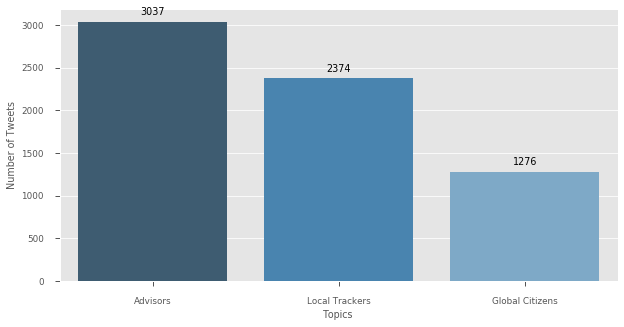

In [246]:
# Visualise contribution of each topics to Reddit Posts on COVID-19

#### Plot settings ####
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
matplotlib.rcParams['font.family'] = "DejaVu Sans"
plt.rcParams['figure.figsize'] = [10, 5]
sns.set_context('paper')
####


# Plot chart
ax = sns.countplot(x="Dominant_Topic_Label",
                    data=df_dominant_topic,
                    order = df_dominant_topic['Dominant_Topic_Label'].value_counts().index,
                    palette=("Blues_d"))


# Add value labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

    
# Change width of bars
# def change_width(ax, new_value) :
#     for patch in ax.patches :
#         current_width = patch.get_width()
#         diff = current_width - new_value

#         # we change the bar width
#         patch.set_width(new_value)

#         # we recenter the bar
#         patch.set_x(patch.get_x() + diff * .5)
# change_width(ax, .60)


# Add axis labels
ax.set(xlabel='Topics', ylabel='Number of Tweets')


# plt.savefig('twitter_topic_contribution.png', dpi=400, transparent=True, bbox_inches="tight")

#### Get The Most Representative Sentence Of Each Topic

In [258]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9623,"time, mask, patient, pandemic, help, please, safe, look, good, news","[wearing, surgical, mask, help, prevent, flu, spreading, youre, well, considerate, wear, mask, w..."
1,1.0,0.9675,"turkey, evil, world, medical, proud, peace, muhammad, prophet, respond, sent","[closed, entire, country, placed, citizen, martial, law, refused, tell, world, chinese, bio, mil..."
2,2.0,0.9618,"singapore, case, first, singaporean, driver, confirmed, thoughtful, grab, new, home","[singapore, report, four, case, bringing, total, number, case, three, singapore, citizen, linked..."


In [ ]:
# Retrieve the representative tweet for topic 0 -- Advisors Conversation Group

topic0_reptext = sent_topics_sorteddf['Representative Text'][0]
topic0_index = processed_tweets.index(topic0_reptext)

topic0_reptweet = tweets_df.iloc[topic0_index]
topic0_reptweet

In [ ]:
# Retrieve the representative tweet for topic 1 -- Global Citizens Conversation Group

topic1_reptext = sent_topics_sorteddf['Representative Text'][1]
topic1_index = processed_tweets.index(topic1_reptext)

topic1_reptweet = tweets_df.iloc[topic1_index]
topic1_reptweet

In [262]:
# Retrieve the representative tweet for topic 2 -- Local Trackers Conversation Group

topic2_reptext = sent_topics_sorteddf['Representative Text'][2]
topic2_index = processed_tweets.index(topic2_reptext)

topic2_reptweet = tweets_df.iloc[topic2_index]
topic2_reptweet

username                                                                                                       deweysim
text                b'Singapore reports four more cases of the #CoronavirusOutbreak, bringing total number of cases ...
date                                                                                                         2020-02-05
processed_tweets    Singapore reports four more cases of the CoronavirusOutbreak bringing total number of cases to 2...
Name: 5494, dtype: object

#### Visualise Model

In [251]:
import pyLDAvis.gensim

In [252]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(ldamodel, corpus_vect, dictionary)

C:\Users\Xiao Rong\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [253]:
# Show visualisation
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.201353  0.264966       1        1  37.486752
0     -0.161063 -0.285359       2        1  33.125008
1      0.362416  0.020393       3        1  29.388243, topic_info=    Category        Freq       Term       Total  loglift  logprob
117  Default  847.000000  singapore  847.000000  30.0000  30.0000
108  Default  637.000000       case  637.000000  29.0000  29.0000
452  Default  503.000000     turkey  503.000000  28.0000  28.0000
413  Default  451.000000       evil  451.000000  27.0000  27.0000
147  Default  430.000000      world  430.000000  26.0000  26.0000
..       ...         ...        ...         ...      ...      ...
236   Topic3   60.438946     closed   61.159962   1.2127  -5.0178
11    Topic3  172.434708    chinese  321.760193   0.6008  -3.9695
441   Topic3  138.938156       grab  394.038635   0.1822  -4.1855
9     Topic3   93.227783      video  171.900513   0.6127  -4.5844
80    Topic3   95.444931       mask  295.214233   0.0954  -4.5609

[141 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
221       1  0.751045     2020
221       2  0.241716     2020
444       2  0.997360       80
450       3  0.999358      aid
193       2  0.983451  another
...     ...       ...      ...
130       3  0.993452    watch
319       2  0.986465     well
343       3  0.993506    woman
273       1  0.990825     work
147       3  0.998050    world

[125 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [254]:
# Save visualisation to html page
# pyLDAvis.save_html(p, 'twitter_lda.html')

### Finalise Model with Pickle

In [255]:
import pickle

#save model to disk
# pickle.dump(ldamodel, open("twitter_lda", "wb"))

In [ ]:
#load model from disk
ldamodel = pickle.load(open("twitter_lda2", 'rb'))
for num ,topic in ldamodel.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(num)+": "+ topic)

### Save & Restore Notebook Session

In [ ]:
# !pip install dill

In [256]:
import dill

In [257]:
#save notebook session
dill.dump_session('twitter_lda.db')

In [ ]:
#restore notebook session
dill.load_session('twitter_lda.db')